In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from keras.models import Sequential
from keras.layers import UpSampling2D
from keras.layers import Conv2D
import numpy as np
import imageio
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

Using TensorFlow backend.


In [3]:
# Load the dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
BUFFER_SIZE = 60000 #num of images
BATCH_SIZE = 256 #batches of images

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Basically creating a seed (random noise to create the initial image )
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
        # We can use higher learning rates because batch normalization makes sure that there’s no activation that’s gone really high or really low
    model.add(layers.BatchNormalization())
    # We use LeakyReLU as described in the paper
    model.add(layers.LeakyReLU())
    # we reshape without having to change any of the data
    # the current shape is (None, 12544) and we change that to (7, 7, 256)
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

# The generator uses these upsampling layers to create an image from a seed (random noise)
    # the transpose convolutional layer (Conv2DTranspose) that performs an inverse convolution operation.
    # conv2dtranspose also known as down sampling
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # we output into a 1 dimensional array to make 
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [15]:
generator = make_generator_model()
# this is the input data
# random 1 to 100 and normalize it
noise = tf.random.normal([1, 100])
print("input :", noise)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
generator = make_generator_model()



(None, 12544)


AssertionError: 

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # basically makes the smaller
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
# Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)



tf.Tensor([[-0.00133227]], shape=(1, 1), dtype=float32)


In [16]:
# we define the losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
# Discriminator loss
# This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss

# The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



In [18]:
# we train both of the 2 network differently using adam 
# Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
#save the checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,     discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [20]:
# Define the training pattern

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
seed = tf.random.normal([num_examples_to_generate, noise_dim])



# The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

# Notice the use of `tf.function` which makes the function to be "compiled" or being faster as in a greedy execution
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # basically a class that resolves gradient
    # aka https://en.wikipedia.org/wiki/Automatic_differentiation

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # making the fake tapes
      generated_images = generator(noise, training=True)
      # critic on both fake and real images
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      # figure out the loss from the fake images
      gen_loss = generator_loss(fake_output)
      # see the difference from both the real and fake
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))




In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [22]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


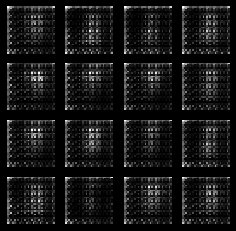

Time for epoch 1 is 293.6875190734863 sec


KeyboardInterrupt: 

In [23]:
%%time
train(train_dataset, EPOCHS)